In [1]:
!pip install pygimli tetgen


# 2D Refraction modelling and inversion

This example shows how to use the TravelTime manager to generate the response
of a three-layered sloping model and to invert the synthetic noisified data.


In [3]:
import numpy as np
import pygimli as pg
import pygimli.meshtools as mt
import pygimli.physics.traveltime as tt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Model setup
We start by creating a three-layered slope (The model is taken from the BSc
thesis of Constanze Reinken conducted at the University of Bonn).



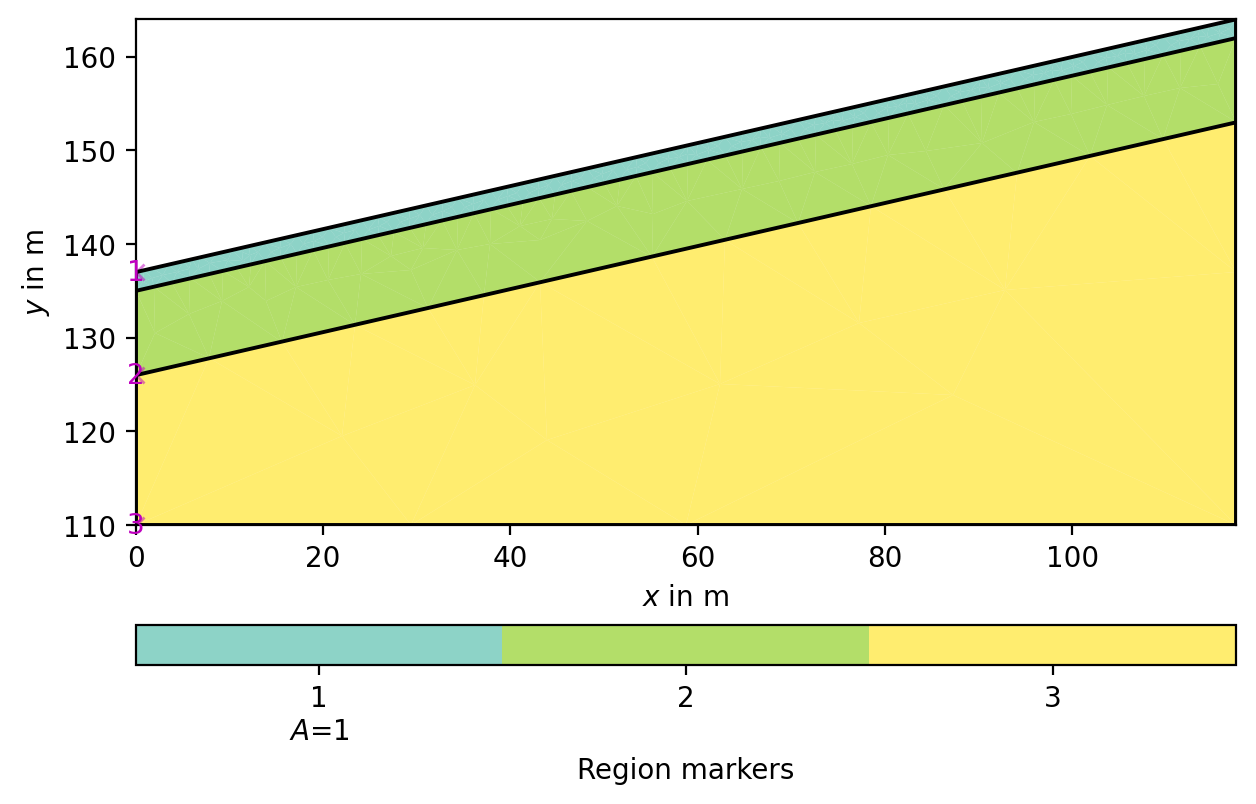

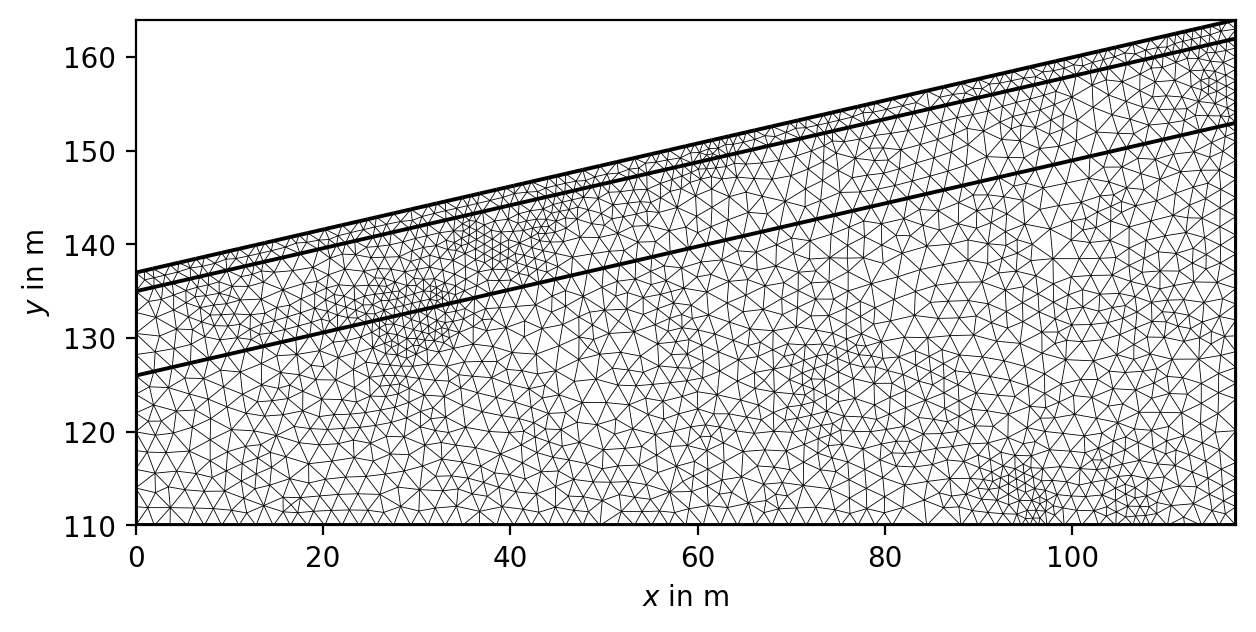

In [4]:
layer1 = mt.createPolygon([[0.0, 137], [117.5, 164], [117.5, 162], [0.0, 135]],
                          isClosed=True, marker=1, area=1)
layer2 = mt.createPolygon([[0.0, 126], [0.0, 135], [117.5, 162], [117.5, 153]],
                          isClosed=True, marker=2)
layer3 = mt.createPolygon([[0.0, 110], [0.0, 126], [117.5, 153], [117.5, 110]],
                          isClosed=True, marker=3)

geom = layer1 + layer2 + layer3

# If you want no sloping flat earth geometry .. comment out the next 3 lines
# geom = mt.createWorld(start=[0.0, 110], end=[117.5, 137],
#                       layers=[137-2, 137-11])
# slope = 0.0

pg.show(geom)

mesh = mt.createMesh(geom, quality=34.3, area=3, smooth=[1, 10])
ax, _ = pg.show(mesh)

Next we define geophone positions and a measurement scheme, which consists of
shot and receiver indices.



In [5]:
numberGeophones = 48
sensors = np.linspace(0., 117.5, numberGeophones)
scheme = tt.createRAData(sensors, shotDistance=3)

# Adapt sensor positions to slope
slope = (164 - 137) / 117.5
pos = np.array(scheme.sensors())
for x in pos[:, 0]:
    i = np.where(pos[:, 0] == x)
    new_y = x * slope + 137
    pos[i, 1] = new_y

scheme.setSensors(pos)

## Synthetic data generation
Now we initialize the TravelTime manager and asssign P-wave velocities to the
layers. To this end, we create a map from cell markers 0 through 3 to
velocities (in m/s) and generate a velocity vector. To check whether the
model looks correct, we plot it along with the sensor positions.



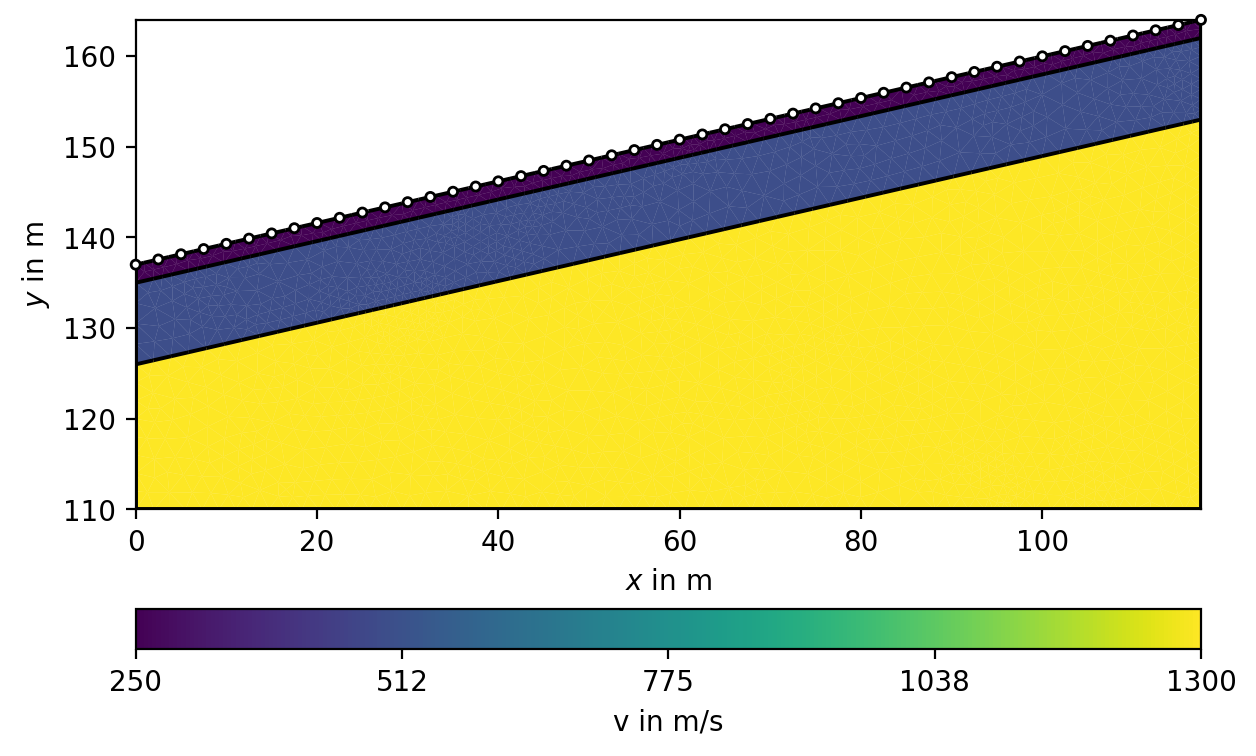

In [6]:
vp = np.array(mesh.cellMarkers())
vp[vp == 1] = 250
vp[vp == 2] = 500
vp[vp == 3] = 1300

ax, _ = pg.show(mesh, vp, colorBar=True, logScale=False, label='v in m/s')
pg.viewer.mpl.drawSensors(ax, scheme.sensors(), diam=1.0,
                         facecolor='white', edgecolor='black')

We use this model to create noisified synthetic data and look at the
traveltime data matrix. Note, we force a specific noise seed as we want
reproducable results for testing purposes.



INFO:pyGIMLi:Creating refined mesh (secnodes: 2) to solve forward task.
28/10/25 - 21:40:01 - pyGIMLi - INFO - Creating refined mesh (secnodes: 2) to solve forward task.


min/max t: 0.008790995543598544 0.14101993727141837


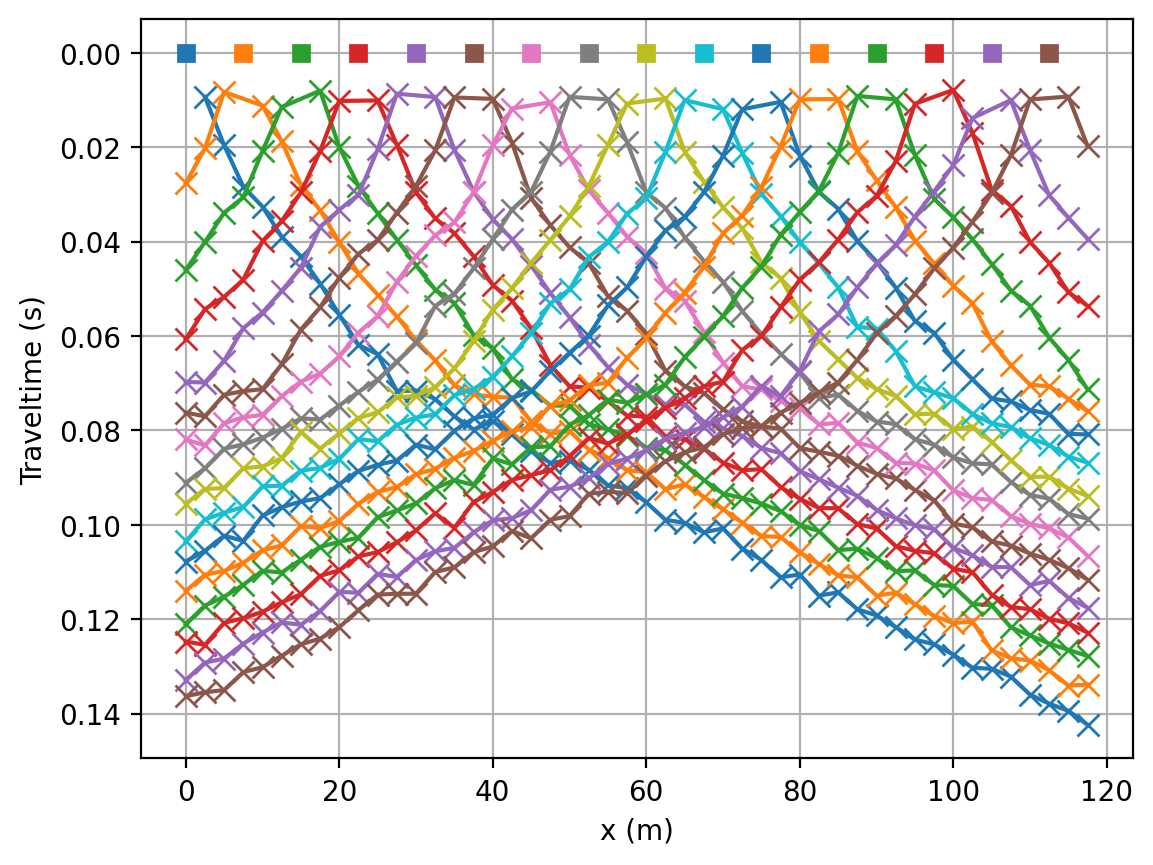

In [7]:
data = tt.simulate(slowness=1.0 / vp, scheme=scheme, mesh=mesh,
                   noiseLevel=0.001, noiseAbs=0.001, seed=1337, verbose=True)
tt.show(data)

## Inversion
Now we invert the synthetic data. We need a new independent mesh without
information about the layered structure. This mesh can be created manual or
guessd automatic from the data sensor positions (in this example). We
tune the maximum cell size in the parametric domain to 15m²



In [8]:
mgr = tt.TravelTimeManager(data)
vest = mgr.invert(secNodes=2, paraMaxCellSize=15.0,
                  maxIter=10, verbose=True)
np.testing.assert_array_less(mgr.inv.inv.chi2(), 1.1)

INFO:pyGIMLi:Found 1 regions.
28/10/25 - 21:40:10 - pyGIMLi - INFO - Found 1 regions.
INFO:pyGIMLi:Found 1 regions.
28/10/25 - 21:40:10 - pyGIMLi - INFO - Found 1 regions.
INFO:pyGIMLi:Creating forward mesh from region infos.
28/10/25 - 21:40:10 - pyGIMLi - INFO - Creating forward mesh from region infos.
INFO:pyGIMLi:Creating refined mesh (secnodes: 2) to solve forward task.
28/10/25 - 21:40:10 - pyGIMLi - INFO - Creating refined mesh (secnodes: 2) to solve forward task.
INFO:pyGIMLi:Create gradient starting model. 500: 5000
28/10/25 - 21:40:10 - pyGIMLi - INFO - Create gradient starting model. 500: 5000
INFO:pyGIMLi:Created startmodel from forward operator:1198, min/max=0.000200/0.002000
28/10/25 - 21:40:10 - pyGIMLi - INFO - Created startmodel from forward operator:1198, min/max=0.000200/0.002000
INFO:pyGIMLi:Starting inversion.
28/10/25 - 21:40:10 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.traveltime.modelling.TravelTimeDijkstraModelling object at 0x787ee4dc84f0>
Data transformation: Identity transform
Model transformation: Logarithmic transform
min/max (data): 0.0079/0.14
min/max (error): 0.8%/12.81%
min/max (start model): 2.0e-04/0.002
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  626.79
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =    3.26 (dPhi = 99.39%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    1.93 (dPhi = 37.34%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    1.35 (dPhi = 22.91%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² =    1.09 (dPhi = 15.24%) lam: 20.0
------------------------------------------------------------------

The manager also holds the method showResult that is used to plot the result.
Note that only covered cells are shown by default.
For comparison we plot the geometry on top.



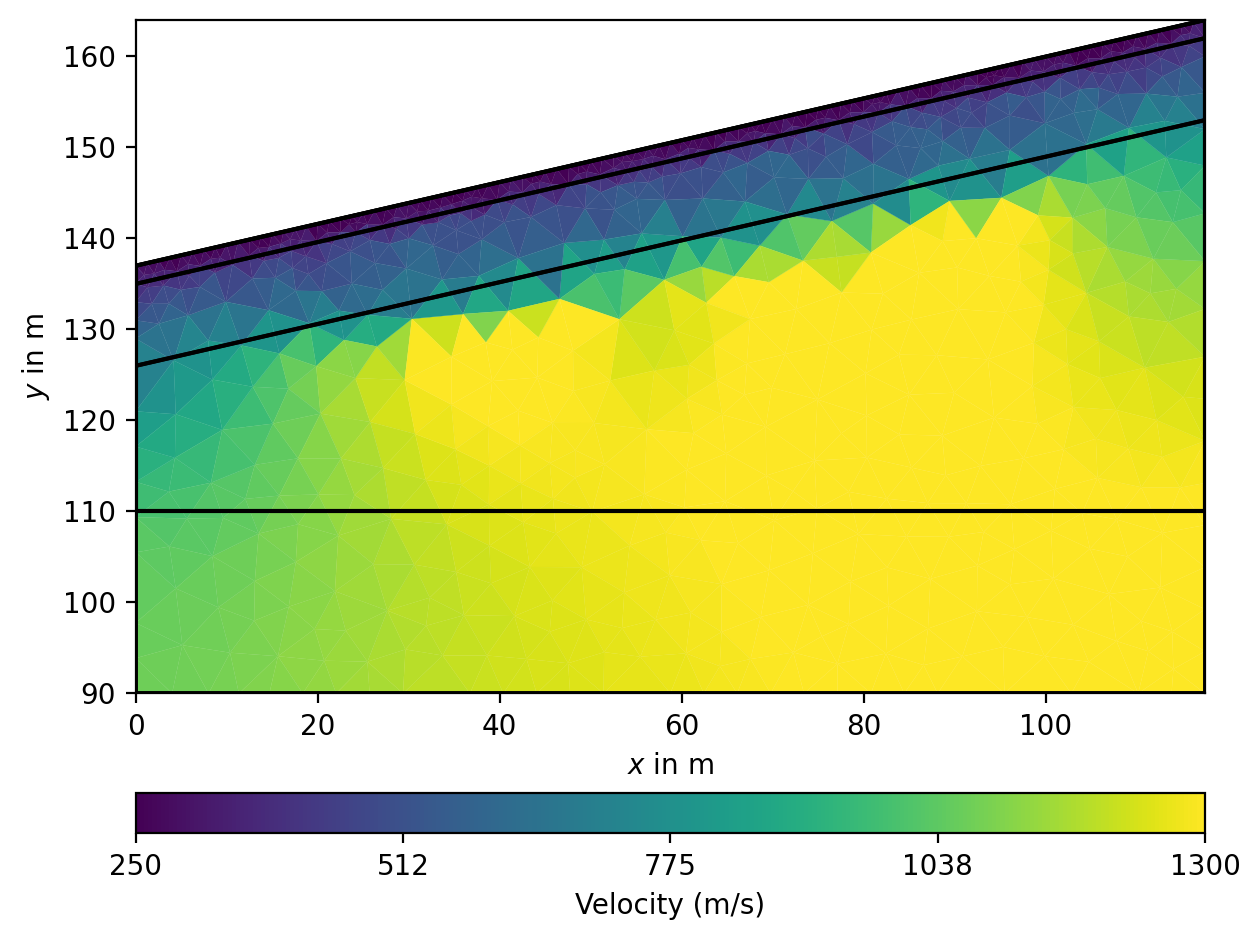

In [9]:
ax, _ = mgr.showResult(cMin=min(vp), cMax=max(vp), logScale=False)
ax, _ = pg.show(geom, ax=ax, fillRegion=False, regionMarker=False)

Note that internally the following is called

```python
ax, _ = pg.show(ra.mesh, vest, label="Velocity [m/s]", **kwargs)
```


It is always important to have a look at the data fit.



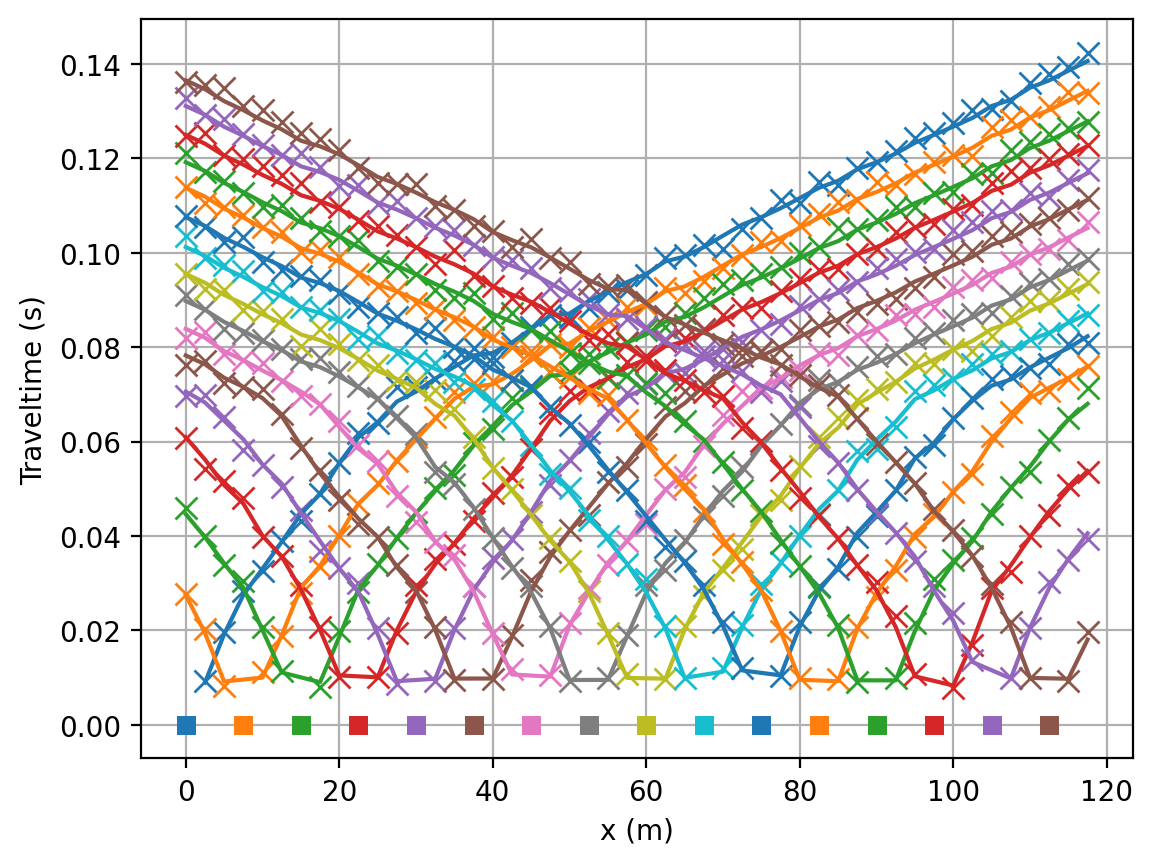

In [10]:
mgr.showFit(firstPicks=True)